In [1]:
#Tratamiento de datos

import pandas as pd 
import numpy as np 

# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar linealidad de las relaciones entre las variables y la distribución de las variables

import scipy.stats as stats
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

# ver todas las columnas
pd.set_option('display.max_columns', None)
# ver todas las filas
pd.set_option('display.max_rows', None)

# Gestión de los warnings

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_customer = pd.read_csv('Customer_data_clean.csv', on_bad_lines='skip', index_col = 0)

df_customer.head(3)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year
0,100018,2017,1,3,0,3,1521,152,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.000000,Married,Aurora,7919.20,Standard,2016,8,1900
1,100102,2017,1,10,4,14,2030,203,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,79441.628829,Single,Nova,2887.74,Standard,2013,3,1900
2,100140,2017,1,6,0,6,1200,120,0,0,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,79441.628829,Divorced,Nova,2838.07,Standard,2016,7,1900


### BONUS

In [3]:
#Filtrado por cliente:

clientes  = df_customer.groupby('Loyalty Number').agg({'Flights Booked': 'sum', 'Education': 'first', 'Gender': 'first'}).reset_index()

In [4]:
# Existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes?
# 1. Preparación de Datos: Filtra el conjunto de datos para incluir únicamente las columnas relevantes:'Flights Booked' y 'Education'.

df1 = clientes[['Flights Booked', 'Education']]

df1.head(5)

,Flights Booked,Education
0,157,Bachelor
1,173,College
2,152,College
3,79,Bachelor
4,127,Bachelor


In [5]:
#2. Análisis Descriptivo: Agrupa los datos por nivel educativo y calcula estadísticas descriptivas
#básicas (como el promedio, la desviación estándar) del número de vuelos reservados para cada grupo.

clientes.groupby("Education")["Flights Booked"].agg(["mean", "median", "std", "var", "min", "max"]) 

,mean,median,std,var,min,max
Education,,,,,,
Bachelor,99.120983,113.0,54.237917,2941.751694,0,354
College,100.613025,113.0,54.208810,2938.595082,0,324
Doctor,100.866485,115.0,55.933391,3128.544223,0,292
High School or Below,101.069142,115.0,54.881017,3011.925982,0,265
Master,101.602362,113.0,54.023146,2918.500349,0,322


In [6]:
#Cuantos clientes tienen un total de 0 vuelos reservados? 
print(f'El total de clientes con 0 vuelos reservados es de: {(clientes["Flights Booked"] == 0).sum()}')

El total de clientes con 0 vuelos reservados es de: 1500


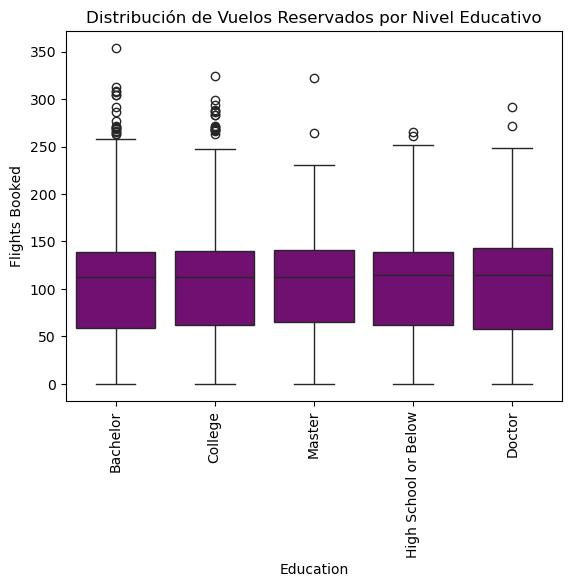

In [7]:
#Visualización de los datos para ver los resultados atípicos:

sns.boxplot(x="Education", y="Flights Booked", data=clientes, color='purple')
plt.xticks(rotation=90)
plt.title("Distribución de Vuelos Reservados por Nivel Educativo")
plt.show()

#Vemos que la media es igual en todos los niveles educativos pero hay más valores atípicos en las clientas 'Bachelor'

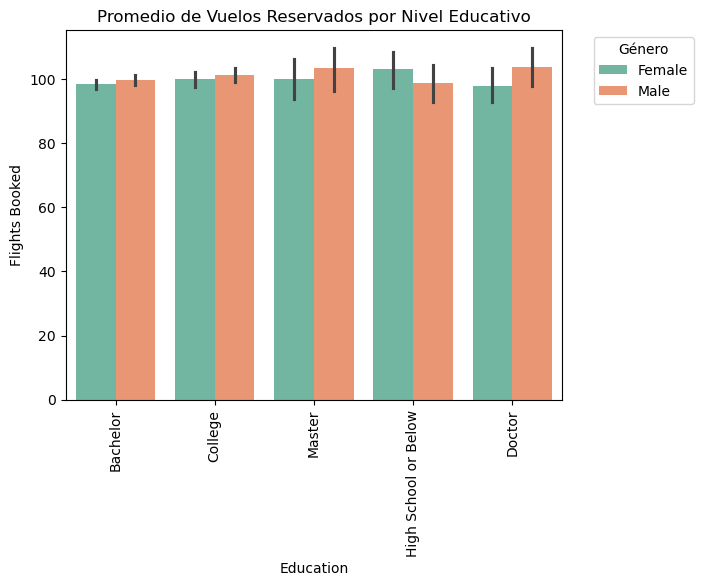

In [8]:
#Visualización para ver más claro el total de vuelos reservados:
#Le añado género con 'hue' para ver si hay diferencias significativas

sns.barplot(x="Education", y="Flights Booked", data=clientes, estimator='mean', palette='Set2', hue='Gender')
plt.xticks(rotation=90)
plt.title("Promedio de Vuelos Reservados por Nivel Educativo")
plt.legend(title="Género", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#Esto muestra que en todos los niveles educativos menos en el de 'High School or Below' reservan más vuelos hombres que mujeres, aunque la diferencia baja.

In [9]:
#3. Prueba Estadística: Realiza una prueba de hipótesis para determinar si existe una diferencia
# significativa en el número de vuelos reservados entre los diferentes niveles educativos.


In [10]:
def prueba_hipotesis(*args):
    """
    Realiza una prueba de hipótesis para comparar grupos.
    1. Primero verifica si los datos son normales usando el test de Shapiro-Wilk o Kolmogorov-Smirnov.
    2. Si los datos son normales, usa Bartlett para probar igualdad de varianzas. Si no son normales, usa Levene.
    3. Si las varianzas son iguales, usa el t-test de Student; si no, usa la versión de Welch.
    4. Si los datos no son normales, usa el test de Mann-Whitney

    Parámetros:
    *args: listas o arrays con los datos de cada grupo. Espera DOS grupos a comparar

    Retorna:
    dict con resultados del test de normalidad, varianza e hipótesis.
    """
    
    # Verificar si hay al menos dos grupos
    if len(args) < 2:
        raise ValueError("Se necesitan al menos dos conjuntos de datos para realizar la prueba.")
    
    # Comprobar normalidad en cada grupo
    normalidad = []
    for grupo in args:
        if len(grupo) > 50: #aquí vamos a decidir hacer komogorov porque es más potente y shapiro solo en muestras pequeñas
            p_valor_norm = stats.kstest(grupo, 'norm').pvalue  # Kolmogorov-Smirnov si n > 50
        else:
            p_valor_norm = stats.shapiro(grupo).pvalue  # Shapiro-Wilk si n <= 50
        normalidad.append(p_valor_norm > 0.05)

    datos_normales = all(normalidad)  # True si todos los grupos son normales, all() solo devuelve True si todos los elementos son True

    # Prueba de igualdad de varianzas
    if datos_normales:
        p_valor_varianza = stats.bartlett(*args).pvalue  # Test de Bartlett si los datos son normales
    else:
        p_valor_varianza = stats.levene(*args, center="median").pvalue  # Test de Levene si al menos un grupo no es normal

    varianzas_iguales = p_valor_varianza > 0.05

    # Aplicar el test adecuado
    if datos_normales:
        if varianzas_iguales:
            t_stat, p_valor = stats.ttest_ind(*args, equal_var=True)
            test_usado = "t-test de Student (varianzas iguales)"
        else:
            t_stat, p_valor = stats.ttest_ind(*args, equal_var=False)
            test_usado = "t-test de Welch (varianzas desiguales)"
    else:
        t_stat, p_valor = stats.mannwhitneyu(*args)
        test_usado = "Mann-Whitney U"

    # Nivel de significancia
    alfa = 0.05

    # Resultados
    resultado = {
        "Test de Normalidad": normalidad,
        "Datos Normales": datos_normales,
        "p-valor Varianza": p_valor_varianza,
        "Varianzas Iguales": varianzas_iguales,
        "Test Usado": test_usado,
        "Estadístico": t_stat,
        "p-valor": p_valor,
        "Conclusión": "Rechazamos H0. Es decir, sí hay diferencias significativas)" if p_valor < alfa else "No se rechaza H0. Es decir, no hay diferencias significativas"
    }

    # Imprimir resultados de manera más clara
    print("\n📊 **Resultados de la Prueba de Hipótesis** 📊")
    print(f"✅ Test de Normalidad: {'Sí' if datos_normales else 'No'}")
    print(f"   - Normalidad por grupo: {normalidad}")
    print(f"✅ Test de Varianza: {'Iguales' if varianzas_iguales else 'Desiguales'} (p = {p_valor_varianza:.4f})")
    print(f"✅ Test aplicado: {test_usado}")
    print(f"📉 Estadístico: {t_stat:.4f}, p-valor: {p_valor:.4f}")
    print(f"🔍 Conclusión: {resultado['Conclusión']}\n")


#Creo dos grupos diferenciados por nivel de educacion:
nivel_educativo_basico = clientes[clientes['Education'].isin(['High School or Below', 'Bachelor'])]['Flights Booked']
nivel_educativo_alto = clientes[clientes['Education'].isin(['College','Master', 'Doctor'])]['Flights Booked']

prueba_hipotesis(nivel_educativo_basico, nivel_educativo_alto)


📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [False, False]
✅ Test de Varianza: Iguales (p = 0.9986)
✅ Test aplicado: Mann-Whitney U
📉 Estadístico: 30358333.5000, p-valor: 0.1410
🔍 Conclusión: No se rechaza H0. Es decir, no hay diferencias significativas

